# <center><font color='blue'>Identifying lead effects of COVID cases in TEXAS</font></center>  
<center>Dhruv Arora</center>  
<center>dharora@uw.edu</center>  
<center>12/04/2020</center>

# Motivation and Problem Statement

The COVID-19 pandemic has caused unprecedented public health and economic crises. Texas has surpassed California in recording the highest number of positive coronavirus cases in the U.S as of Nov'20. I have an interest in doing statistical data analysis to attempt to uncover data-driven insights that are not easy to find over the internet or have not uncovered yet, to best of my knowledge. I want to apply my data science skills to explore COVID-19 data for Texas state and come up with research questions that can potentially help different govt. agencies to make proactive data driven decisions and regulations.   

My plan is to focus on understanding the relationship between confirmed positive cases, hospitalization and ICU patients. If I am able to establish a significant relationship of any kind, it can help in multiple ways. My hypothesis is to verify if there is any "lead effect" exist - "increase in positive cases" leads to "increase in hospitalization" X days later. The idea is similar to websites like "Redfin" i.e. increase in "pending" state of listed homes leads to increase in "sales" of home after 60 days on average. There are lot of covid hospitalization forecast models out there but answering the analytical questions like this can help agencies to make proactive data driven decisions and can also help forecasters to refine the features as learned from this analysis. 

I will also be exploring the relationship between hospitalization and ICU patients i.e. does increase in hospitalization lead to increase in ICU patients X day later. If we are able to find a lead effect, it can help in effecient resource management of ICU beds. The specific research questions are mentioned later in the document.

# Data

The data is available on [Covidtracking.com](https://covidtracking.com/) which is a volunteer organization launched from The Atlantic and dedicated to collecting and publishing the data required to understand the COVID-19 outbreak in the United States. The site collects the data from all 50 states and their data is being used by national and local news organizations across the US.  
#### Link to the Dataset: [Here](https://covidtracking.com/data/api)
#### Link to the Data Defintions: [Here](https://covidtracking.com/about-data/data-definitions)
#### Terms and Conditions for the Data: [Here](https://covidtracking.com/terms-and-conditions). 
The Datasource is one of the reliable sources of COVID data collection and also used by John Hopkins for its testing insights initiative. The website collects data by bottom up approach i.e. rolls up data from each county of the State. It report different metrics that captures various nuances such as over all testing, NPR testing, "probable" testing when not available and much more detailed metrics. The data granularity is at day level and each state which makes upto 13k rows and 45 dimensions. There do not seem to be any ethical considerations for using the dataset.

# Unknowns and dependencies


The dataset have time-series of different metrics related to COVID-19. There is known issue in data collection process that states cannot report daily newly admitted hospitalizations and newly ICU patients. However, we have access to the alternative metrics such as active hospitalization count and active ICU patients count which can be used as proxy for the analysis. Also, the source reports the quality of data being collected for each state and Texas's data quality is graded as "A" which is considered sufficiently good enough.

# Research questions

<font color='#C24914'><b>1. Research Question:</b> Is there a statistically significant relationship between COVID positive cases in Texas and rise in hospitalization X days later?</font>   

 <b>Hypothesis:</b> <font color='#C24914'>We want to test the null hypothesis that increase in positive cases in Texas do not lead to an increase in hospitalization X days later.</font>   
 As of today, Texas has most active number of positive COVID cases in the U.S. Our hypothesis is that the number of positive cases has "lead effect" on hospitalization i.e. number of people tested positive today will impact the number of hospitalization after X days.   
    
   
<font color='#C24914'><b>2. Research Question</b>:  Is there a statistically significant relationship between Hospitalization in Texas and rise in ICU patients X days later?</font>     

 <b>Hypothesis:</b> <font color='#C24914'>We want to test the null hypothesis that Increase in Hospitalization in Texas do not lead to an increase in ICU patients X days later.</font>  
 Our hypothesis is that COVID patients getting hospitalized today may have lead effect on ICU beds later in time.  

# Related Work

1. <b> [CDC's COVID hospitalization forecast](https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/hospitalizations-forecasts.html#:~:text=Interpretation%20of%20Forecasts%20of%20New%20Hospitalizations&text=For%20December%207%2C%20the%20forecasts,which%20results%20from%20multiple%20factors) </b> - The forecast models are available from different modelling groups using variety of data such as syndromic, clinical, demographic, and mobility data etc. The model relies on multi-variate data to build forecast model. However, we are interested in an analytical question to understand the statistical relationship between positive cases, hospitalization and ICU beds. The analytical question can help agencies making data driven decisions with out a forecast model and can also help forecasters refine features for modelling.

# Methodology 

<font color='#C24914'><b>1. Research Question:</b> Is there a statistically significant relationship between COVID positive cases in Texas and rise in hospitalization X days later?</font>  

We approach to investigate this research question in multiple steps:
1. Data preparation: Define the time-series metrics for positive cases and hospitalization that are robust and valid for the analysis
2. Visualize the relationship between the defined metrics to explore the list of valid statistical tests
3. Test the assumptions of identified valid statistical test and revise the tests as needed
4. Run the test and evaluate the results


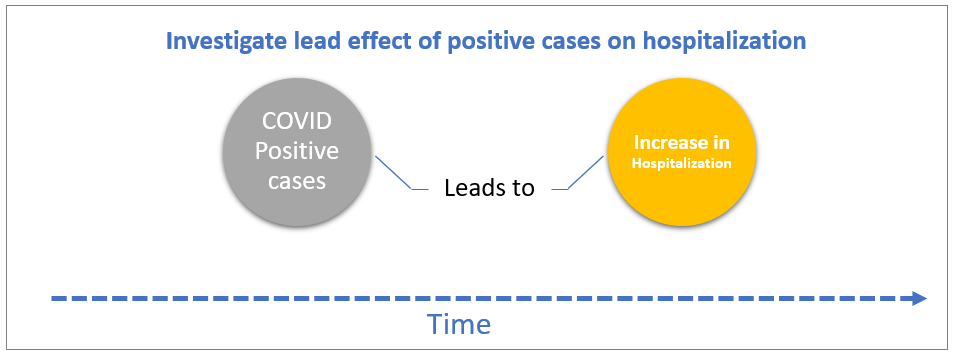

### Step1: Data Preparation and Metrics Derivation  

The foremost step is to instantiate the COVID data API and its parameters for TEXAS state.

In [61]:
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from colorama import Fore

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams


COVID_TEXAS_API = "https://covidtracking.com/api/v1/states/tx/daily.csv"
START_DATE_ANALYSIS, END_DATE_ANALYSIS = "2020-04-05", "2020-12-02"

Load the raw from covid tracking api for TEXAS state and start deriving the metrics for analysis:  

a. <b>Active Cases:</b> This metric is defined as total number of confirmed cases of COVID-positive cases active in TEXAS on a particular day. This is a derived metric, estimated by subtracting recovered cases from total positive cases up to a single date.  

b. <b>Active Hospitalization Count:</b> This metric is defined as total individuals who are currently hospitalized with COVID-19. This metric is available in the dataset.  

c. <b>Hospitalization Rate:</b> This metric is defined as percentage of Active Hospitalization Count divided by Active Cases.  

Note: As per the [COVID tracking data collection process](https://covidtracking.com/about-data/data-definitions), it is not feasible to report new hospitalization count on daily basis. Therefore, we need to define our metrics on "active" basis instead daily metric. The data quality grade for Texas is also shown below as "A" which is considered good quality.

In [62]:
#load data from api
df = pd.read_csv(COVID_TEXAS_API)
df.to_csv("data/COVID_dataset.csv")#saving the dataset for backup
df["date"]= pd.to_datetime(df['date'], format='%Y%m%d')#convert to date
df = df.loc[(df.date >=  START_DATE_ANALYSIS) & (df.date <= END_DATE_ANALYSIS)] #filter on specific dates
df = df.sort_values("date").reset_index(drop=True)

#derive metrics
df['Active Cases'] = df['positive']-df['recovered'] #derived metric
df['Active Hospitalization Count'] = df['hospitalizedCurrently']#renaming
df['Hospitalization Rate'] = df['Active Hospitalization Count']*100.0/df['Active Cases'] #derived metric
df['Active ICU Count'] = df['inIcuCurrently']#renaming
df['ICU Rate'] = df['Active ICU Count']*100.0/df['Active Hospitalization Count'] #derived metric

#show data
df[['date', 'state', 'dataQualityGrade', 'Active Cases', 'Active Hospitalization Count', 'Hospitalization Rate', \
    'positive' ,'recovered','Active ICU Count', 'ICU Rate']].tail(10)

,date,state,dataQualityGrade,Active Cases,Active Hospitalization Count,Hospitalization Rate,positive,recovered,Active ICU Count,ICU Rate
232,2020-11-23,TX,A,183240.0,8353.0,4.558503,1100979,917739.0,2299.0,27.523046
233,2020-11-24,TX,A,188040.0,8495.0,4.517656,1115371,927331.0,2331.0,27.439670
234,2020-11-25,TX,A,195969.0,8585.0,4.380795,1130980,935011.0,2356.0,27.443215
235,2020-11-26,TX,A,200159.0,8706.0,4.349542,1143616,943457.0,2444.0,28.072594
236,2020-11-27,TX,A,200382.0,8518.0,4.250881,1147045,946663.0,2449.0,28.750880
237,2020-11-28,TX,A,200483.0,8597.0,4.288144,1151069,950586.0,2427.0,28.230778
238,2020-11-29,TX,A,202808.0,8634.0,4.257229,1157273,954465.0,2487.0,28.804726
239,2020-11-30,TX,A,205472.0,8900.0,4.331490,1168111,962639.0,2536.0,28.494382
240,2020-12-01,TX,A,207733.0,9047.0,4.355110,1184250,976517.0,2583.0,28.550901
241,2020-12-02,TX,A,207523.0,9109.0,4.389393,1200674,993151.0,2544.0,27.928422


### Step2: Visualize the relationships between time-series metric  

Let's visualize the relationship between the defined metrics in step 1:  

<b>In graph 1</b>, We observe that the Active Cases and Active Hospitalization Count vary together over time. The lines slopping together practically begging to believe that correlation exists. We all know that the truism "Correlation doesn't imply casuation". Statistically, we can't make the leap that any relationship exists. The time-series may suffer from [spurious correlations](https://tylervigen.com/spurious-correlations) due to the existence of trend in data. Most of the statistical tests rely on assumption of [stationary time-series](https://otexts.com/fpp2/stationarity.html) i.e. time-series whose properties do not depend on the time at which series is observed. Such spurious correlation exists all over the place such as [US spending on science and technology highly correlates with Suicides](https://tylervigen.com/spurious-correlations) visually. We will keep a note to stationarize  our metrics by trying different [order of integration](https://www.statisticshowto.com/order-of-integration/).

<b>In graph 2</b>, it is astonishing to see that hospitalization rate has been decling over time. The steepest drop has been seen between July and September. Along with [weather variable](https://weatherspark.com/y/8813/Average-Weather-in-Dallas-Texas-United-States-Year-Round) as cofounding, we can see there are some other unobserved variables in play that has lead to declining hospitalization rate in TEXAS.

Our focus is to find the lead effect of positive active cases on active hospitalization. Therefore, we will validate the assumptions of [Granger Casuality Statistical Test](https://www.statisticshowto.com/granger-causality/) before running the test. We will also transform our series as needed for the test. Note that with Granger causality, we aren’t testing a true cause-and-effect relationship; What we want to know is if a particular variable comes before another in the time series. In other words, if we find Granger causality in our data there isn’t a causal link in the true sense of the word (for example, sales of Easter baskets Granger-cause Easter!).

Few other notes:  
1. Please note that Active Hospitalization Count is plotted on secondary y-axis as its values are low comparatively to Active Hospitalization.   
2. The [Total Texas Hospital capacity is 64K beds](https://www.dshs.texas.gov/coronavirus/additionaldata/) and active hospitalization is under 20% through the data so we can ignore the logistic assumption i.e. the hospitalization reached it capacity.



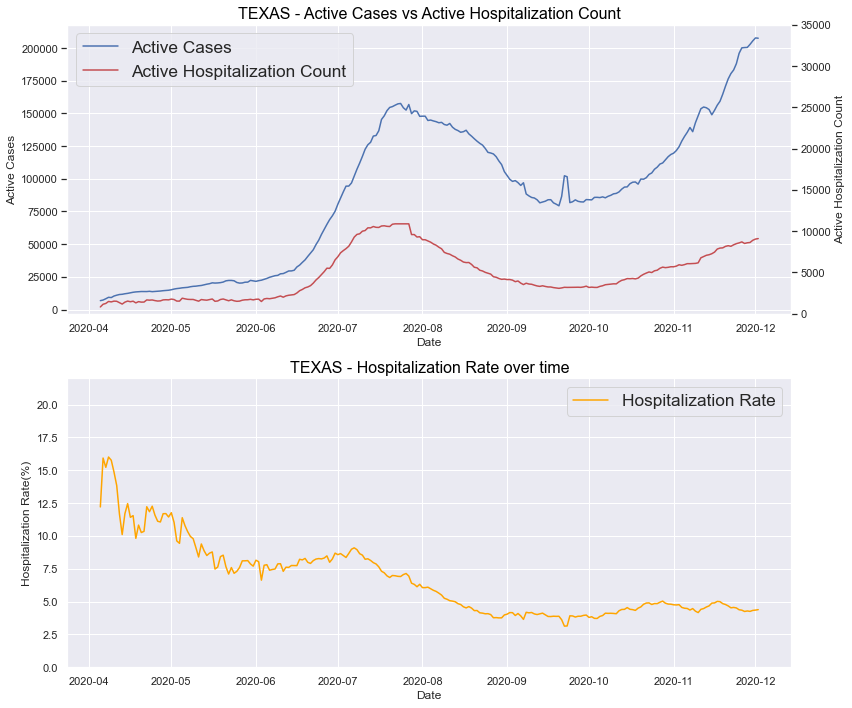

In [39]:
#figure properties
fig, ax = plt.subplots(2,figsize=(12,10))

#create metrics for visualization
plot_df = df[['date', 'Active Cases', 'Active Hospitalization Count', 'Hospitalization Rate']].copy()


#plot 1: testing vs cases vs hospitalization
ax[0].plot('date', 'Active Cases', data=plot_df);
ax[0].set_xlabel('Date');
ax[0].set_ylabel('Active Cases');
#second y axis
ax_0_twin = ax[0].twinx()
ax_0_twin.plot('date', 'Active Hospitalization Count',data=plot_df, color='r');
ax_0_twin.set_ylabel('Active Hospitalization Count');
ax_0_twin.set_ylim(bottom=-0, top=35000)
ax_0_twin.grid(None)
#subplot properties and legends
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax_0_twin.get_legend_handles_labels()
ax_0_twin.legend(lines + lines2, labels + labels2, loc=2, fontsize='x-large')
ax[0].set_title('TEXAS - Active Cases vs Active Hospitalization Count',fontsize= 16);
ax[0].title.set_color('black');

#plot 2: Hospitalization Rate over time
ax[1].plot('date', 'Hospitalization Rate', data=plot_df, color='orange');
ax[1].set_xlabel('Date');
ax[1].set_ylabel('Hospitalization Rate(%)');
ax[1].set_ylim(bottom=-0, top=22)
#subplot properties and legends
lines, labels = ax[1].get_legend_handles_labels()
ax[1].legend(lines, labels, loc=0, fontsize='x-large')
ax[1].set_title('TEXAS - Hospitalization Rate over time',fontsize= 16);
ax[1].title.set_color('black');

plt.tight_layout();
plt.savefig('Visualizations/Active Cases vs Hospitalization vs Hospitalization Rate.png')
plt.show();

### Step3: Validate the Granger Causality test assumptions  

There are mainly two assumptions for Granger Causality test:

1. Time-series are <b>stationary</b> (i.e., the mean and variance of each time series do not change over time):  
Let's run [Augemted Dickey Fuller (ADF)](statisticshowto.com/adf-augmented-dickey-fuller-test/) test to validate if our time-series are stationary. The null hypothesis for this test is that there is a unit root. The alternate hypothesis is that the time series is stationary (or trend-stationary). We can see below that our stationarity test fails so we had to apply [two order differencing](https://www.statisticshowto.com/order-of-integration/) after log transformation to make the time-series stationarity for both of our metrics. We will use the same [two order differencing](https://www.statisticshowto.com/order-of-integration/) on time-series for granger casuality test assuming 99% significance level.  


2. Second assumption for our time-series that it is adequately described by a linear model i.e. <b>normality assumption</b>.  
We  test the normality assumption after stationarity assumption by plotting the histogram. The histogram suggests that samples approximately follow normal distribution.

Stationarity Test:

In [25]:
import statsmodels.tsa.stattools as ts

#*** Active Hospitalization Count
#before any differencing
result = ts.adfuller(np.log(df['Active Hospitalization Count']).dropna())
print(Fore.RED +'Hospitalization metric before  differencing')
print(Fore.BLACK +'ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#after first level differencing
result = ts.adfuller(np.log(df['Active Hospitalization Count']).diff().dropna())
print(Fore.RED +'Hospitalization metric before first order of differencing')
print(Fore.BLACK +'ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#after second level differencing
result = ts.adfuller(np.log(df['Active Hospitalization Count']).diff().diff().dropna())
print(Fore.RED +'Hospitalization metric before second order of differencing')
print(Fore.BLACK +'ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#*** Active Cases
#before any differencing
result = ts.adfuller(np.log(df['Active Cases']).dropna())
print(Fore.RED +'Active Cases before  differencing')
print(Fore.BLACK +'ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#after first level differencing
result = ts.adfuller(np.log(df['Active Cases']).diff().dropna())
print(Fore.RED +'Active Cases metric before first order of differencing')
print(Fore.BLACK +'ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#after second level differencing
result = ts.adfuller(np.log(df['Active Cases']).diff().diff().dropna())
print(Fore.RED +'Active Cases metric before second order of differencing')
print(Fore.BLACK +'ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

Hospitalization metric before  differencing
ADF Statistic: -2.708159
p-value: 0.072637
Hospitalization metric before first order of differencing
ADF Statistic: -1.594960
p-value: 0.486125
Hospitalization metric before second order of differencing
ADF Statistic: -4.905321
p-value: 0.000034
Active Cases before  differencing
ADF Statistic: -1.083975
p-value: 0.721420
Active Cases metric before first order of differencing
ADF Statistic: -3.239563
p-value: 0.017806
Active Cases metric before second order of differencing
ADF Statistic: -10.115098
p-value: 0.000000


Normality Plot:

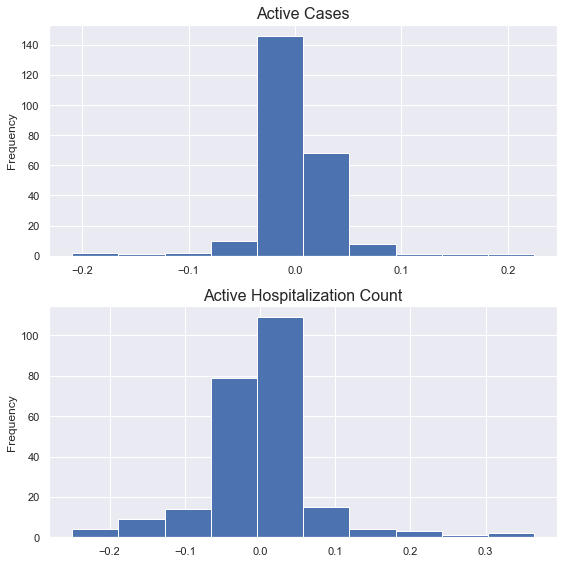

In [44]:
fig, ax = plt.subplots(2,figsize=(8,8))
ax[0].hist(np.log(df[['Active Cases']]).diff().diff().dropna().values.flatten());
ax[0].set_title('Active Cases', fontsize= 16)
ax[0].set_ylabel('Frequency');
ax[1].hist(np.log(df[['Active Hospitalization Count']]).diff().diff().dropna().values.flatten());
ax[1].set_title('Active Hospitalization Count' ,fontsize= 16);
ax[1].set_ylabel('Frequency');
fig.tight_layout() 

### Step4: Run the Granger Causality test on stationarized time-series  
The first parameter in [granger casuality test function](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html) is the variable on which the lead effect is to be estimated i.e. Active Hospitalization Count. We ran the test on 30 lags to validate the statistical relationship. The null hypothesis for the test is that the increase in positive cases in Texas does not lead to increase in hospitalization X days later. We are assuming 99% significance level. 

As shown in the test results below, we could not establish the statistically significant relationship on any lag value of positive active cases based on "parameter F test". Therefore, we could not reject the null hypothesis.

In [27]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

granger_df = df[['date', 'Active Cases', 'Active Hospitalization Count']].sort_values('date').copy()

#second level differencing as identified by ADF test
granger_df.loc[:, 'Active Cases'] = granger_df['Active Cases'].diff().diff()
granger_df.loc[:, 'Active Hospitalization Count'] = granger_df['Active Hospitalization Count'].diff().diff()
granger_df.dropna(inplace=True)

result = grangercausalitytests(granger_df[['Active Hospitalization Count','Active Cases']], 30, verbose=True);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9362  , p=0.3343  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=0.9481  , p=0.3302  , df=1
likelihood ratio test: chi2=0.9462  , p=0.3307  , df=1
parameter F test:         F=0.9362  , p=0.3343  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3573  , p=0.6999  , df_denom=233, df_num=2
ssr based chi2 test:   chi2=0.7299  , p=0.6942  , df=2
likelihood ratio test: chi2=0.7288  , p=0.6946  , df=2
parameter F test:         F=0.3573  , p=0.6999  , df_denom=233, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1890  , p=0.3147  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=3.6756  , p=0.2987  , df=3
likelihood ratio test: chi2=3.6474  , p=0.3021  , df=3
parameter F test:         F=1.1890  , p=0.3147  , df_denom=230, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9638  , p=0.4281  

We plot the p-value for each lag of Active Positive Cases. We also draw a red line to denote 95% significance level. We could not find any statistical relationship between lagged value of active cases and hospitalization.

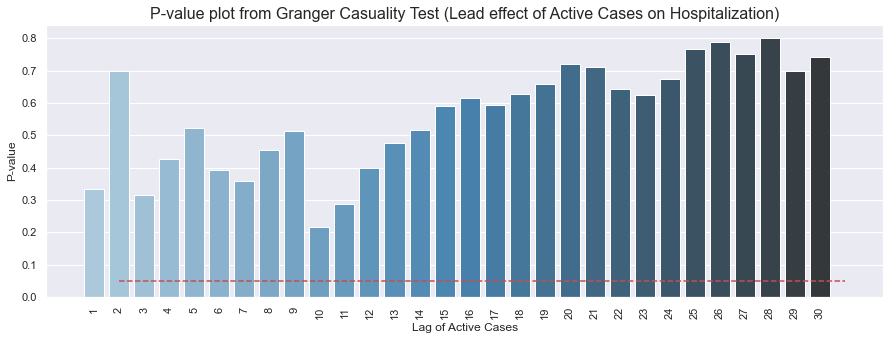

In [38]:
pvalue_list=[]
lag_list = []
for key in result.items():
    lag_list.append(key[0])
    f_statistics = key[1][0].get('params_ftest')[0]
    p_value = key[1][0].get('params_ftest')[1]
    pvalue_list.append(p_value)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=lag_list, y=pvalue_list, palette="Blues_d");
plt.xticks(rotation=90);
plt.hlines(y=.05, xmin=1, xmax=30, color='r', linestyle='--')
plt.xlabel('Lag of Active Cases')
plt.ylabel('P-value')
plt.title('P-value plot from Granger Casuality Test (Lead effect of Active Cases on Hospitalization)',\
          fontdict = {'fontsize' : 16});
plt.savefig('Visualizations/Granger Casuality Test- Active Cases on hospitalization.png')

<font color='#C24914'><b>2. Research Question:</b> Is there a statistically significant relationship between hospitalization in Texas and rise in ICU patients X days later?</font>  

We approach to investigate this research question in the same way as done for earlier question and we are going to reuse the code and make changes only if the assumptions of the tests are voilated. Here are the metrics derived and their observed relationship by visualization.

a. <b>Active ICU Count:</b> This metric is defined as total number of individuals who are currently hospitalized in the Intensive Care Unit with COVID-19.  

b. <b>Active Hospitalization Count:</b> This metric is defined as total individuals who are currently hospitalized with COVID-19.We can observe some relationship between hospitalization and ICU but we have to be careful of [spurios correlations](https://tylervigen.com/spurious-correlations) as before.    

c. <b>ICU Rate:</b> This metric is defined as percentage of Active ICU Count divided by Active Hospitalization Count. We can observe that ICU rate initially decreased and started increasing after thanksgiving weekend.

Note that ICU data starts from 07/22. Hence, we are using the hospitalization data from approximately 1 month before to find the lead effects.

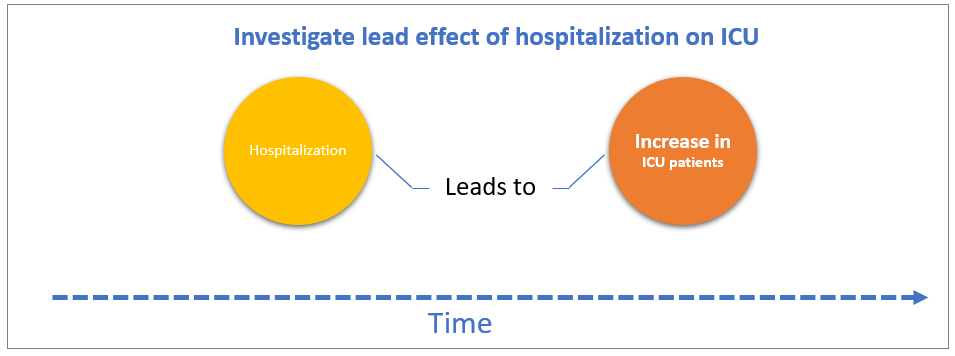

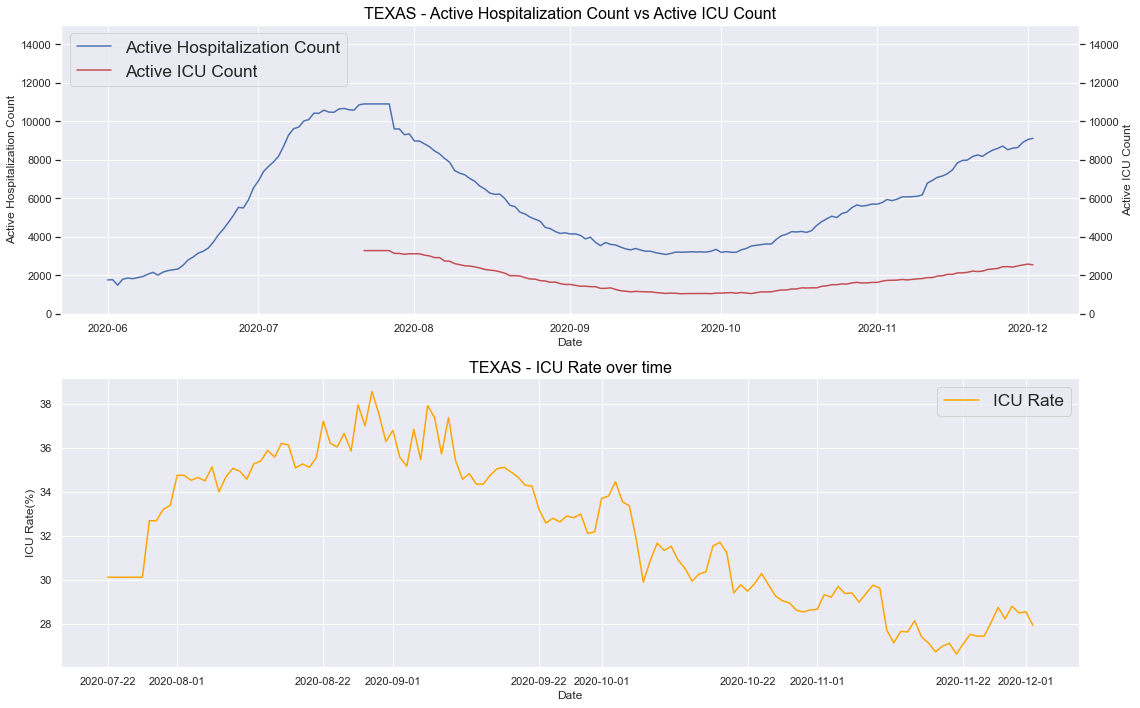

In [53]:
#figure properties
fig, ax = plt.subplots(2,figsize=(16,10))

#create metrics for visualization
plot_df = df[['date', 'Active ICU Count', 'Active Hospitalization Count', 'ICU Rate']].copy()
plot_df = plot_df.loc[plot_df.date>='2020-06-01']

#plot 1: testing vs cases vs hospitalization
ax[0].plot('date', 'Active Hospitalization Count', data=plot_df);
ax[0].set_xlabel('Date');
ax[0].set_ylabel('Active Hospitalization Count');
ax[0].set_ylim(bottom=-0, top=15000)
#second y axis
ax_0_twin = ax[0].twinx()
ax_0_twin.plot('date', 'Active ICU Count',data=plot_df, color='r');
ax_0_twin.set_ylabel('Active ICU Count');
ax_0_twin.set_ylim(bottom=-0, top=15000)
ax_0_twin.grid(None)
#subplot properties and legends
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax_0_twin.get_legend_handles_labels()
ax_0_twin.legend(lines + lines2, labels + labels2, loc=2, fontsize='x-large')
ax[0].set_title('TEXAS - Active Hospitalization Count vs Active ICU Count',fontsize= 16);
ax[0].title.set_color('black');

#plot 2: Hospitalization Rate over time
ax[1].plot('date', 'ICU Rate', data=plot_df, color='orange');
ax[1].set_xlabel('Date');
ax[1].set_ylabel('ICU Rate(%)');
#ax[1].set_ylim(bottom=22, top=45)
#subplot properties and legends
lines, labels = ax[1].get_legend_handles_labels()
ax[1].legend(lines, labels, loc=0, fontsize='x-large')
ax[1].set_title('TEXAS - ICU Rate over time',fontsize= 16);
ax[1].title.set_color('black');

plt.tight_layout();
plt.savefig('Visualizations/Hospitalization vs ICU beds vs ICU Rate.png')
plt.show();

Augmented Dickey Fuller Test (ADF) test for stationarity: We reject the null hypothesis that time-series have unit root as p-value is less than .01 for significance level 99%. We can directly use the time-series in granger casuality test.

Hospitalization metric before  differencing
ADF Statistic: -3.382706
p-value: 0.011563
Active ICU Count before  differencing
ADF Statistic: -3.602909
p-value: 0.005706


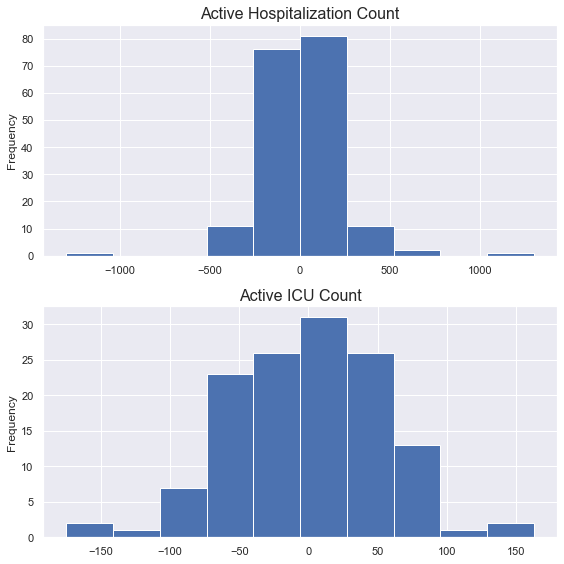

In [54]:
import statsmodels.tsa.stattools as ts

test_df = df[['date', 'Active ICU Count', 'Active Hospitalization Count']].copy()
test_df = test_df.loc[test_df.date>='2020-06-01']

#*** Active Hospitalization Count
#before any differencing
result = ts.adfuller(test_df['Active Hospitalization Count'].dropna())
print(Fore.RED +'Hospitalization metric before  differencing')
print(Fore.BLACK +'ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#*** Active ICU Count
#before any differencing
result = ts.adfuller(test_df['Active ICU Count'].dropna())
print(Fore.RED +'Active ICU Count before  differencing')
print(Fore.BLACK +'ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

fig, ax = plt.subplots(2,figsize=(8,8))
ax[0].hist(test_df[['Active Hospitalization Count']].diff().diff().dropna().values.flatten());
ax[0].set_title('Active Hospitalization Count', fontsize= 16)
ax[0].set_ylabel('Frequency');
ax[1].hist(test_df[['Active ICU Count']].diff().diff().dropna().values.flatten());
ax[1].set_title('Active ICU Count' ,fontsize= 16);
ax[1].set_ylabel('Frequency');
fig.tight_layout()

Let's run the granger casuality test. We can see that p-value less than .01 up to 17 lags for "paramter F test":

In [55]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

granger_df = df[['date', 'Active ICU Count', 'Active Hospitalization Count']].sort_values('date').copy()
granger_df = granger_df.loc[granger_df.date>='2020-07-22'].copy()

#second level differencing as identified by ADF test
granger_df.loc[:, 'Active Hospitalization Count'] = granger_df['Active Hospitalization Count']
granger_df.loc[:, 'Active ICU Count'] = granger_df['Active ICU Count']
granger_df.dropna(inplace=True)

result = grangercausalitytests(granger_df[['Active ICU Count','Active Hospitalization Count']], 30, verbose=True);
pvalue_list=[]
lag_list = []
for key in result.items():
    lag_list.append(key[0])
    f_statistics = key[1][0].get('params_ftest')[0]
    p_value = key[1][0].get('params_ftest')[1]
    pvalue_list.append(p_value)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=97.8363 , p=0.0000  , df_denom=130, df_num=1
ssr based chi2 test:   chi2=100.0941, p=0.0000  , df=1
likelihood ratio test: chi2=74.6254 , p=0.0000  , df=1
parameter F test:         F=97.8363 , p=0.0000  , df_denom=130, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=45.6504 , p=0.0000  , df_denom=127, df_num=2
ssr based chi2 test:   chi2=94.8953 , p=0.0000  , df=2
likelihood ratio test: chi2=71.5027 , p=0.0000  , df=2
parameter F test:         F=45.6504 , p=0.0000  , df_denom=127, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=17.2753 , p=0.0000  , df_denom=124, df_num=3
ssr based chi2 test:   chi2=54.7517 , p=0.0000  , df=3
likelihood ratio test: chi2=45.7470 , p=0.0000  , df=3
parameter F test:         F=17.2753 , p=0.0000  , df_denom=124, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.4609 , p=0.0000  

Let's plot the p-value for each of the lag of hospitalization metric on ICU beds. We can observe that p-value is less than .01 upto 17 lags of active hospitalization metric. Therefore, we have evidence to reject the null hypothesis that increase in hospitalization does not lead to increase in ICU patients up to 17 days later.

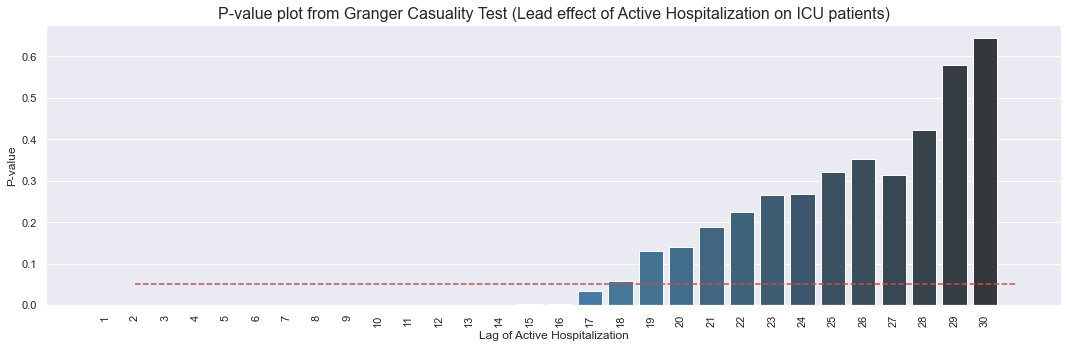

In [60]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=lag_list, y=pvalue_list, palette="Blues_d");
plt.xticks(rotation=90);
plt.hlines(y=.05, xmin=1, xmax=30, color='r', linestyle='--')
plt.xlabel('Lag of Active Hospitalization')
plt.ylabel('P-value')
plt.title('P-value plot from Granger Casuality Test (Lead effect of Active Hospitalization on ICU patients)',\
          fontdict = {'fontsize' : 16});
plt.savefig('Visualizations/Granger Casuality Test- Active Hospitalization on ICU.png')
plt.tight_layout();

# Findings  
Here are the main findings from the analysis and few interesting insights:  

1. <font color='#C24914'>We could not find the evidence to reject the null hypothesis that increase in active covid cases in TEXAS leads to increase in active hospitalization X days later.</font> The p-value for granger casuality hypothesis test is found to be greater than .05 assuming 95% significance level for all the lags up to 30 of active covid cases.

2. <font color='#C24914'>We found evidence to reject the null hypothesis that increase in active hospitalization in TEXAS leads to increase in ICU beds up to 17 days later.</font> The p-value for granger casuality hypothesis test is found to be less than .05 assuming 95% significance level for lags up to 17 days.   


3. The hospitalization rate has shown to be decling trend over time and tends to increase in recent months. This suggests that there are other cofounding factors that affects the hospitalization and not just getting positive COVID test. The potential factors can be [weather](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7321777/), human fear of disease decaying as more information gets available or other unknown cofounding factors interacting with each other.   


4. The ICU rate has shown to be decling over time and tend to increase after thanksgiving weekend. We are able to find statistical significant relationship between hospitalization and ICU beds.

# Implications  & Future Work
The statistical outcome of both research questions are surprising and can potentially be useful for efficient health care resource management for the Texas department of state and health services. The uncovered insights from first research question  suggests that there is no correlation between positive cases and hospitalization, could encourage other researchers to identify other cofounding factors that leads to higher hospitalization and plan proactively for health care resources. There is a research paper published which suggests that there is high correlation between [weather and impact of COVID](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7321777/). The steep drop in hospitalization over time around summer, and again an increase in winter also supports weather theory. However, there is  clearly a need for additional work to provide data driven statistical evidence to it.  

The uncovered insights from second research question suggests that an increase in hospitalization leads to an increase in ICU patients up to 17 days later. The lead effect of hospitalization on ICU beds/patients is significant. This can potentially help Texas healthcare agencies to proactively plan for ICU beds whenever seen an increase in hospitalization up to 17 days later. This study also signals to use active hospitalization lag feature in forecasting ICU beds requirement over time.

The main limitation of the analysis is the non-availibility of daily metrics such as daily newly admitted individuals or daily newly admitted ICU patients. However, we were able to overcome this by using active metrics such as daily active hospitalizations or daily active ICU patients which acts as proxy of daily metrics. If state govt. can provide daily data on these metrics could be more helpful to understand the day lag relationship.


# Conclusion & Reflection  

<font color='#C24914'>1. Research Question: Is there a statistically significant relationship between COVID positive cases in Texas and rise in hospitalization X days later?</font>  
Null hypothesis: Increase in positive cases in Texas do not lead to increase in hospitalization X days later.  
Alternate hypothesis: Increase in positive cases in Texas lead to increase in hospitalization X days later.  
<font color='#C24914'>Outcome of hypothesis test:</font> We did not find evidence to reject the null hypothesis.  
   
   
<font color='#C24914'>2. Research Question:  Is there a statistically significant relationship between Hospitalization in Texas and rise in ICU patients X days later?</font>    
Null hypothesis: Increase in positive cases in Texas do not lead to increase in hospitalization X days later.   
Alternate hypothesis: Increase in hospitalization in Texas lead to increase in Active ICU Count X days later.  
<font color='#C24914'>Outcome of hypothesis test:</font> We did find evidence to reject the null hypothesis and found that increase in hospitalization lead to increase in ICU patients up to 17 days later.  

From a human-centered data science perspective, this study uncover insights that can enable Texas department of state and health services to plan proactively for ICU beds up to 17 days by monitoring the early detector signal such as active hospitalization count. The study also informs about the steep drop in hospitalization over summer and raise questions on dynamically changing impact of COVID-19. Furthermore, the analysis can be repeated over time as more data is collected, and post winter in Texas, to establish weather theory. The COVID-19 has caused unprecented public health and economic crises and we are all in this together. 

# References
[1]  [Granger Casuality Test in Python](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html)  
[2]  [Augmented Dickey Fuller Test in Python](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)  
[3]  [Terms and Conditions for Data Source](https://covidtracking.com/terms-and-conditions)  
[4]  [Texas department of state and health services reporting events on COVID](https://dshs.texas.gov/coronavirus/AdditionalData.aspx)  
[5]  [Coronovirus reporting website - Worldometer](https://www.worldometers.info/coronavirus/country/us/)  
[6]  [Spurious Correlation Examples](https://tylervigen.com/spurious-correlations)  
[7]  [Does weather affect the growth rate of COVID-19](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7321777/)